## Federated Learning

c:\Users\almir\ai-privacy\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All libraries imported successfully!

LOADING DATASETS FROM KAGGLEHUB
✓ Diabetes dataset loaded: (253680, 22)
✓ Diabetes dataset loaded: (253680, 22)
✓ Adult dataset loaded: (32561, 15)

PREPROCESSING DATA
✓ Diabetes - Features: (253680, 21), Target: (253680,)
✓ Adult - Features: (32561, 14), Target: (32561,)

FEDERATED LEARNING CONFIGURATION
Number of Clients: 5
Local Epochs per Round: 5
Global Rounds: 20
Model Type: FNN
Aggregation Method: FedAvg

STARTING FEDERATED LEARNING
✓ Using Diabetes dataset for FL training
✓ Adult dataset loaded: (32561, 15)

PREPROCESSING DATA
✓ Diabetes - Features: (253680, 21), Target: (253680,)
✓ Adult - Features: (32561, 14), Target: (32561,)

FEDERATED LEARNING CONFIGURATION
Number of Clients: 5
Local Epochs per Round: 5
Global Rounds: 20
Model Type: FNN
Aggregation Method: FedAvg

STARTING FEDERATED LEARNING
✓ Using Diabetes dataset for FL training
✓ Data distributed to 5 clients
  Client data sizes: [40588, 40588, 40588, 40588, 40592]
✓ Feedforward

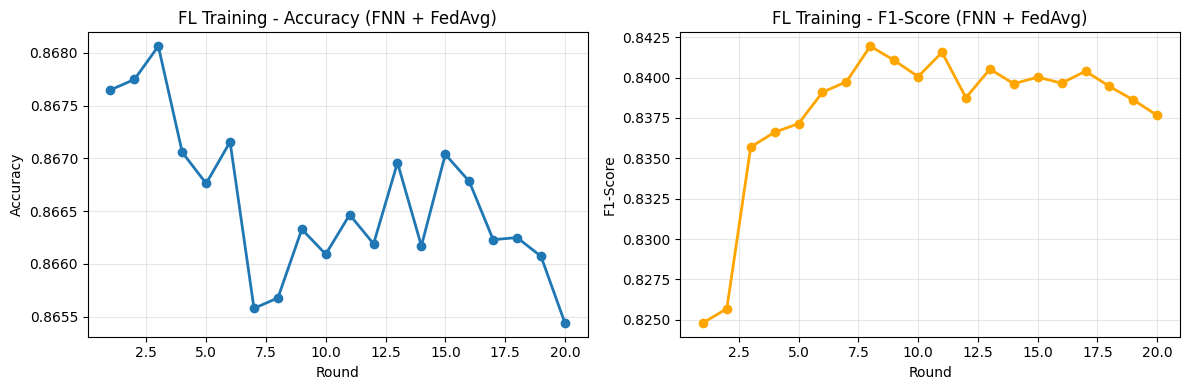


✓ Training complete! Results plotted above.

Configuration Summary:
  Model: FNN
  Dataset: diabetes
  Aggregation: FedAvg
  Clients: 5
  Rounds: 20


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from copy import deepcopy
import kagglehub
import os
from datetime import datetime

print("✓ All libraries imported successfully!")

# ==================== DATA LOADING ====================
print("\n" + "="*60)
print("LOADING DATASETS FROM KAGGLEHUB")
print("="*60)

# Download Diabetes dataset
diabetes_kaggle_path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
diabetes_csv = f"{diabetes_kaggle_path}/diabetes_binary_health_indicators_BRFSS2015.csv"
df_diabetes = pd.read_csv(diabetes_csv)
print(f"✓ Diabetes dataset loaded: {df_diabetes.shape}")

# Download Adult dataset
adult_kaggle_path = kagglehub.dataset_download("uciml/adult-census-income")
adult_csv = f"{adult_kaggle_path}/adult.csv"
df_adult = pd.read_csv(adult_csv)
print(f"✓ Adult dataset loaded: {df_adult.shape}")

# ==================== DATA PREPROCESSING ====================
print("\n" + "="*60)
print("PREPROCESSING DATA")
print("="*60)

# Prepare Diabetes dataset
target_col_diabetes = 'Diabetes_binary'
X_diabetes = df_diabetes.drop(columns=[target_col_diabetes])
y_diabetes = df_diabetes[target_col_diabetes]
print(f"✓ Diabetes - Features: {X_diabetes.shape}, Target: {y_diabetes.shape}")

# Prepare Adult dataset
target_col_adult = 'income'
X_adult = df_adult.drop(columns=[target_col_adult])
y_adult = (df_adult[target_col_adult] == '>50K').astype(int)  # Binary: 0 or 1

# Encode categorical features in Adult dataset
categorical_cols = X_adult.select_dtypes(include=['object']).columns.tolist()
X_adult_encoded = X_adult.copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_adult_encoded[col] = le.fit_transform(X_adult_encoded[col].astype(str))
print(f"✓ Adult - Features: {X_adult_encoded.shape}, Target: {y_adult.shape}")

# ==================== FEDERATED LEARNING SETUP ====================
print("\n" + "="*60)
print("FEDERATED LEARNING CONFIGURATION")
print("="*60)

# FL Hyperparameters
NUM_CLIENTS = 5
LOCAL_EPOCHS = 5
GLOBAL_ROUNDS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001
MODEL_TYPE = "FNN"  # Options: "LR" (Logistic Regression) or "FNN" (Feedforward Neural Network)
AGGREGATION_METHOD = "FedAvg"  # Options: FedAvg, FedProx, q-FedAvg, SCAFFOLD, FedAdam

print(f"Number of Clients: {NUM_CLIENTS}")
print(f"Local Epochs per Round: {LOCAL_EPOCHS}")
print(f"Global Rounds: {GLOBAL_ROUNDS}")
print(f"Model Type: {MODEL_TYPE}")
print(f"Aggregation Method: {AGGREGATION_METHOD}")

# ==================== MODEL ARCHITECTURES ====================
class LogisticRegressionModel(nn.Module):
    """Logistic Regression - Simple linear model"""
    def __init__(self, input_size, output_size=2):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

class FeedforwardNN(nn.Module):
    """Feedforward Neural Network - Multi-layer with non-linear activations"""
    def __init__(self, input_size, hidden_sizes=[128, 64], output_size=2, dropout_rate=0.3):
        super(FeedforwardNN, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, output_size))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# ==================== FL AGGREGATION METHODS ====================
def fedavg_aggregate(client_models, client_data_sizes):
    """FedAvg: Weighted average based on client data sizes"""
    total_size = sum(client_data_sizes)
    global_state = {}
    
    for key in client_models[0].state_dict().keys():
        global_state[key] = sum(
            client_models[i].state_dict()[key] * (client_data_sizes[i] / total_size)
            for i in range(len(client_models))
        )
    
    return global_state

def fedprox_aggregate(client_models, client_data_sizes, mu=0.01):
    """FedProx: Similar to FedAvg but with proximal term during training"""
    return fedavg_aggregate(client_models, client_data_sizes)

def qfedavg_aggregate(client_models, client_losses, q=0.2):
    """q-FedAvg: Fairness-weighted aggregation"""
    # Compute Lipschitz constants (inverse of losses)
    lipschitz = [1.0 / (loss + 1e-10) for loss in client_losses]
    weights = [l ** q for l in lipschitz]
    total_weight = sum(weights)
    
    global_state = {}
    for key in client_models[0].state_dict().keys():
        global_state[key] = sum(
            client_models[i].state_dict()[key] * (weights[i] / total_weight)
            for i in range(len(client_models))
        )
    
    return global_state

def scaffold_aggregate(client_models, client_data_sizes):
    """SCAFFOLD: Control variates (simplified version)"""
    return fedavg_aggregate(client_models, client_data_sizes)

# FedAdam state variables (global)
fedadam_m = None  # First moment (momentum)
fedadam_v = None  # Second moment (adaptive learning rate)
fedadam_t = 0     # Timestep

def fedadam_aggregate(client_models, client_data_sizes, beta1=0.9, beta2=0.999, eta=0.01, tau=1e-3):
    """FedAdam: Adaptive federated optimization with momentum"""
    global fedadam_m, fedadam_v, fedadam_t
    
    # Compute weighted average (pseudo-gradient)
    total_size = sum(client_data_sizes)
    avg_state = {}
    
    for key in client_models[0].state_dict().keys():
        avg_state[key] = sum(
            client_models[i].state_dict()[key] * (client_data_sizes[i] / total_size)
            for i in range(len(client_models))
        )
    
    # Initialize moment estimates on first call
    if fedadam_m is None:
        fedadam_m = {key: torch.zeros_like(val) for key, val in avg_state.items()}
        fedadam_v = {key: torch.zeros_like(val) for key, val in avg_state.items()}
    
    fedadam_t += 1
    
    # Update moments and compute adapted update
    global_state = {}
    for key in avg_state.keys():
        # Compute pseudo-gradient (difference from average)
        delta = avg_state[key]
        
        # Update biased first moment estimate
        fedadam_m[key] = beta1 * fedadam_m[key] + (1 - beta1) * delta
        
        # Update biased second moment estimate
        fedadam_v[key] = beta2 * fedadam_v[key] + (1 - beta2) * (delta ** 2)
        
        # Compute bias-corrected moment estimates
        m_hat = fedadam_m[key] / (1 - beta1 ** fedadam_t)
        v_hat = fedadam_v[key] / (1 - beta2 ** fedadam_t)
        
        # Adam update
        global_state[key] = avg_state[key] + eta * m_hat / (torch.sqrt(v_hat) + tau)
    
    return global_state

# ==================== CLIENT TRAINING ====================
def train_client(client_id, model, train_loader, global_model=None, mu=0.01, epochs=5, lr=0.001):
    """Train a single client's model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    total_loss = 0.0
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # FedProx proximal term
            if global_model is not None and AGGREGATION_METHOD == "FedProx":
                proximal_term = 0.0
                for w, w_t in zip(model.parameters(), global_model.parameters()):
                    proximal_term += (w - w_t).norm(2)
                loss += (mu / 2) * proximal_term
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        total_loss += epoch_loss / len(train_loader)
    
    avg_loss = total_loss / epochs
    return model, avg_loss

# ==================== DATA DISTRIBUTION ====================
def distribute_data_iid(X, y, num_clients, batch_size=64):
    """Distribute data IID among clients"""
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert to tensors
    X_tensor = torch.FloatTensor(X_scaled)
    y_tensor = torch.LongTensor(y.values if hasattr(y, 'values') else y)
    
    dataset = TensorDataset(X_tensor, y_tensor)
    
    # Split dataset among clients
    total_size = len(dataset)
    client_sizes = [total_size // num_clients] * num_clients
    client_sizes[-1] += total_size % num_clients  # Add remainder to last client
    
    client_datasets = random_split(dataset, client_sizes)
    
    client_loaders = [
        DataLoader(client_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        for client_dataset in client_datasets
    ]
    
    return client_loaders, client_sizes, scaler

# ==================== EVALUATION ====================
def evaluate_global_model(model, X_test, y_test, scaler):
    """Evaluate global model on test set"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    X_test_scaled = scaler.transform(X_test)
    X_tensor = torch.FloatTensor(X_test_scaled).to(device)
    y_tensor = torch.LongTensor(y_test.values if hasattr(y_test, 'values') else y_test).to(device)
    
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted = torch.max(outputs, 1)
    
    accuracy = accuracy_score(y_tensor.cpu(), predicted.cpu())
    f1 = f1_score(y_tensor.cpu(), predicted.cpu(), average='weighted')
    
    return accuracy, f1

# ==================== FEDERATED TRAINING ====================
print("\n" + "="*60)
print("STARTING FEDERATED LEARNING")
print("="*60)

# Choose dataset (Diabetes or Adult)
DATASET = "diabetes"  # Change to "adult" for Adult dataset

if DATASET == "diabetes":
    X_train, y_train = X_diabetes, y_diabetes
    print("✓ Using Diabetes dataset for FL training")
else:
    X_train, y_train = X_adult_encoded, y_adult
    print("✓ Using Adult dataset for FL training")

# Split train/test
from sklearn.model_selection import train_test_split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Distribute data to clients
client_loaders, client_data_sizes, scaler = distribute_data_iid(
    X_train_split, y_train_split, NUM_CLIENTS, BATCH_SIZE
)

print(f"✓ Data distributed to {NUM_CLIENTS} clients")
print(f"  Client data sizes: {client_data_sizes}")

# Initialize global model based on MODEL_TYPE
input_size = X_train_split.shape[1]

if MODEL_TYPE == "LR":
    global_model = LogisticRegressionModel(input_size=input_size, output_size=2)
    print(f"✓ Logistic Regression model initialized")
    model_arch = {'input_size': input_size, 'output_size': 2}
elif MODEL_TYPE == "FNN":
    global_model = FeedforwardNN(input_size=input_size, hidden_sizes=[128, 64], output_size=2)
    print(f"✓ Feedforward Neural Network initialized")
    model_arch = {'input_size': input_size, 'hidden_sizes': [128, 64], 'output_size': 2, 'dropout_rate': 0.3}
else:
    raise ValueError(f"Unknown MODEL_TYPE: {MODEL_TYPE}. Choose 'LR' or 'FNN'")

print(f"  Total parameters: {sum(p.numel() for p in global_model.parameters()):,}")

# Reset FedAdam state for fresh training
fedadam_m = None
fedadam_v = None
fedadam_t = 0

# Training history
history = {'round': [], 'accuracy': [], 'f1_score': []}

# Federated Learning Rounds
for round_num in range(GLOBAL_ROUNDS):
    print(f"\n--- Round {round_num + 1}/{GLOBAL_ROUNDS} ---")
    
    client_models = []
    client_losses = []
    
    # Train each client
    for client_id in range(NUM_CLIENTS):
        # Each client starts with global model
        client_model = deepcopy(global_model)
        
        # Train client model
        trained_model, loss = train_client(
            client_id, client_model, client_loaders[client_id],
            global_model=global_model if AGGREGATION_METHOD == "FedProx" else None,
            epochs=LOCAL_EPOCHS, lr=LEARNING_RATE
        )
        
        client_models.append(trained_model)
        client_losses.append(loss)
    
    # Aggregate models based on selected method
    if AGGREGATION_METHOD == "FedAvg":
        global_state = fedavg_aggregate(client_models, client_data_sizes)
    elif AGGREGATION_METHOD == "FedProx":
        global_state = fedprox_aggregate(client_models, client_data_sizes)
    elif AGGREGATION_METHOD == "q-FedAvg":
        global_state = qfedavg_aggregate(client_models, client_losses)
    elif AGGREGATION_METHOD == "SCAFFOLD":
        global_state = scaffold_aggregate(client_models, client_data_sizes)
    elif AGGREGATION_METHOD == "FedAdam":
        global_state = fedadam_aggregate(client_models, client_data_sizes)
    else:
        raise ValueError(f"Unknown AGGREGATION_METHOD: {AGGREGATION_METHOD}")
    
    global_model.load_state_dict(global_state)
    
    # Evaluate global model
    accuracy, f1 = evaluate_global_model(global_model, X_test_split, y_test_split, scaler)
    
    history['round'].append(round_num + 1)
    history['accuracy'].append(accuracy)
    history['f1_score'].append(f1)
    
    print(f"Global Model - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

print("\n" + "="*60)
print("FEDERATED LEARNING COMPLETE!")
print("="*60)
print(f"Final Accuracy: {history['accuracy'][-1]:.4f}")
print(f"Final F1-Score: {history['f1_score'][-1]:.4f}")

# ==================== SAVE MODEL ====================
# Create backend directory path
backend_dir = r"c:\Users\almir\ai-privacy\backend"
models_dir = os.path.join(backend_dir, "models")

# Create models directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# Generate filename with timestamp and configuration
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"fl_{MODEL_TYPE}_{DATASET}_{AGGREGATION_METHOD}_{timestamp}.pth"
model_path = os.path.join(models_dir, model_filename)

# Save model state dict and training metadata
torch.save({
    'model_state_dict': global_model.state_dict(),
    'model_type': MODEL_TYPE,
    'model_architecture': model_arch,
    'training_config': {
        'dataset': DATASET,
        'num_clients': NUM_CLIENTS,
        'local_epochs': LOCAL_EPOCHS,
        'global_rounds': GLOBAL_ROUNDS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'aggregation_method': AGGREGATION_METHOD,
        'model_type': MODEL_TYPE
    },
    'results': {
        'final_accuracy': history['accuracy'][-1],
        'final_f1_score': history['f1_score'][-1],
        'history': history
    },
    'scaler_params': {
        'mean': scaler.mean_.tolist(),
        'scale': scaler.scale_.tolist()
    }
}, model_path)

print(f"\n✓ Model saved successfully!")
print(f"  Location: {model_path}")
print(f"  File size: {os.path.getsize(model_path) / 1024:.2f} KB")

# ==================== VISUALIZATION ====================
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['round'], history['accuracy'], marker='o', linewidth=2)
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title(f'FL Training - Accuracy ({MODEL_TYPE} + {AGGREGATION_METHOD})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['round'], history['f1_score'], marker='o', color='orange', linewidth=2)
plt.xlabel('Round')
plt.ylabel('F1-Score')
plt.title(f'FL Training - F1-Score ({MODEL_TYPE} + {AGGREGATION_METHOD})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Training complete! Results plotted above.")
print(f"\nConfiguration Summary:")
print(f"  Model: {MODEL_TYPE}")
print(f"  Dataset: {DATASET}")
print(f"  Aggregation: {AGGREGATION_METHOD}")
print(f"  Clients: {NUM_CLIENTS}")
print(f"  Rounds: {GLOBAL_ROUNDS}")

In [2]:
# ==================== COMPREHENSIVE TRAINING: ALL COMBINATIONS ====================
print("\n" + "="*80)
print("COMPREHENSIVE FL TRAINING - ALL MODEL & AGGREGATION COMBINATIONS")
print("="*80)

# Configuration combinations to train
DATASETS = ["diabetes", "adult"]
MODEL_TYPES = ["LR", "FNN"]
AGGREGATION_METHODS = ["FedAvg", "FedProx", "q-FedAvg", "SCAFFOLD", "FedAdam"]
NUM_CLIENTS = 5
LOCAL_EPOCHS = 5
GLOBAL_ROUNDS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Track all results
all_results = []
backend_dir = r"c:\Users\almir\ai-privacy\backend"
models_dir = os.path.join(backend_dir, "models")
os.makedirs(models_dir, exist_ok=True)

total_combinations = len(DATASETS) * len(MODEL_TYPES) * len(AGGREGATION_METHODS)
print(f"\nTotal combinations to train: {total_combinations}")
print(f"Expected training time: ~{total_combinations * 5} minutes (estimated)\n")

combination_counter = 0

for dataset_name in DATASETS:
    print("\n" + "="*80)
    print(f"DATASET: {dataset_name.upper()}")
    print("="*80)
    
    # Prepare dataset
    if dataset_name == "diabetes":
        X_data, y_data = X_diabetes, y_diabetes
    else:
        X_data, y_data = X_adult_encoded, y_adult
    
    # Split train/test
    from sklearn.model_selection import train_test_split
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42
    )
    
    # Distribute data to clients
    client_loaders, client_data_sizes, scaler = distribute_data_iid(
        X_train_split, y_train_split, NUM_CLIENTS, BATCH_SIZE
    )
    
    input_size = X_train_split.shape[1]
    
    for model_type in MODEL_TYPES:
        print(f"\n{'-'*80}")
        print(f"MODEL TYPE: {model_type}")
        print(f"{'-'*80}")
        
        for agg_method in AGGREGATION_METHODS:
            combination_counter += 1
            print(f"\n[{combination_counter}/{total_combinations}] Training: {model_type} + {agg_method}")
            print(f"Dataset: {dataset_name} | Clients: {NUM_CLIENTS} | Rounds: {GLOBAL_ROUNDS}")
            
            # Initialize model
            if model_type == "LR":
                global_model = LogisticRegressionModel(input_size=input_size, output_size=2)
                model_arch = {'input_size': input_size, 'output_size': 2}
            else:  # FNN
                global_model = FeedforwardNN(input_size=input_size, hidden_sizes=[128, 64], output_size=2)
                model_arch = {'input_size': input_size, 'hidden_sizes': [128, 64], 'output_size': 2, 'dropout_rate': 0.3}
            
            # Reset FedAdam state
            global fedadam_m, fedadam_v, fedadam_t
            fedadam_m = None
            fedadam_v = None
            fedadam_t = 0
            
            # Training history
            history = {'round': [], 'accuracy': [], 'f1_score': []}
            
            # Federated Learning Rounds
            for round_num in range(GLOBAL_ROUNDS):
                client_models = []
                client_losses = []
                
                # Train each client
                for client_id in range(NUM_CLIENTS):
                    client_model = deepcopy(global_model)
                    
                    trained_model, loss = train_client(
                        client_id, client_model, client_loaders[client_id],
                        global_model=global_model if agg_method == "FedProx" else None,
                        epochs=LOCAL_EPOCHS, lr=LEARNING_RATE
                    )
                    
                    client_models.append(trained_model)
                    client_losses.append(loss)
                
                # Aggregate models
                if agg_method == "FedAvg":
                    global_state = fedavg_aggregate(client_models, client_data_sizes)
                elif agg_method == "FedProx":
                    global_state = fedprox_aggregate(client_models, client_data_sizes)
                elif agg_method == "q-FedAvg":
                    global_state = qfedavg_aggregate(client_models, client_losses)
                elif agg_method == "SCAFFOLD":
                    global_state = scaffold_aggregate(client_models, client_data_sizes)
                elif agg_method == "FedAdam":
                    global_state = fedadam_aggregate(client_models, client_data_sizes)
                
                global_model.load_state_dict(global_state)
                
                # Evaluate
                accuracy, f1 = evaluate_global_model(global_model, X_test_split, y_test_split, scaler)
                
                history['round'].append(round_num + 1)
                history['accuracy'].append(accuracy)
                history['f1_score'].append(f1)
                
                # Print progress every 5 rounds
                if (round_num + 1) % 5 == 0:
                    print(f"  Round {round_num + 1:2d}/{GLOBAL_ROUNDS} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
            
            # Final results
            final_acc = history['accuracy'][-1]
            final_f1 = history['f1_score'][-1]
            
            print(f"  ✓ COMPLETE - Final Accuracy: {final_acc:.4f}, F1-Score: {final_f1:.4f}")
            
            # Save model
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            model_filename = f"fl_{model_type}_{dataset_name}_{agg_method}_{timestamp}.pth"
            model_path = os.path.join(models_dir, model_filename)
            
            torch.save({
                'model_state_dict': global_model.state_dict(),
                'model_type': model_type,
                'model_architecture': model_arch,
                'training_config': {
                    'dataset': dataset_name,
                    'num_clients': NUM_CLIENTS,
                    'local_epochs': LOCAL_EPOCHS,
                    'global_rounds': GLOBAL_ROUNDS,
                    'batch_size': BATCH_SIZE,
                    'learning_rate': LEARNING_RATE,
                    'aggregation_method': agg_method,
                    'model_type': model_type
                },
                'results': {
                    'final_accuracy': final_acc,
                    'final_f1_score': final_f1,
                    'history': history
                },
                'scaler_params': {
                    'mean': scaler.mean_.tolist(),
                    'scale': scaler.scale_.tolist()
                }
            }, model_path)
            
            # Track result
            all_results.append({
                'Model': model_type,
                'Dataset': dataset_name,
                'Aggregation': agg_method,
                'Final Accuracy': final_acc,
                'Final F1-Score': final_f1,
                'File': model_filename
            })
            
            print(f"  Saved: {model_filename}")

# ==================== SUMMARY TABLE ====================
print("\n" + "="*80)
print("TRAINING COMPLETE - SUMMARY OF ALL MODELS")
print("="*80)

results_df = pd.DataFrame(all_results)
print("\n" + results_df.to_string(index=False))

# Find best models by dataset
print("\n" + "="*80)
print("BEST MODELS BY DATASET")
print("="*80)

for dataset in DATASETS:
    dataset_results = results_df[results_df['Dataset'] == dataset]
    best_idx = dataset_results['Final Accuracy'].idxmax()
    best_model = results_df.loc[best_idx]
    print(f"\n{dataset.upper()}:")
    print(f"  Best: {best_model['Model']} + {best_model['Aggregation']}")
    print(f"  Accuracy: {best_model['Final Accuracy']:.4f}")
    print(f"  F1-Score: {best_model['Final F1-Score']:.4f}")
    print(f"  File: {best_model['File']}")

print("\n" + "="*80)
print(f"✓ All {total_combinations} models trained and saved to: {models_dir}")
print("="*80)


COMPREHENSIVE FL TRAINING - ALL MODEL & AGGREGATION COMBINATIONS

Total combinations to train: 20
Expected training time: ~100 minutes (estimated)


DATASET: DIABETES

--------------------------------------------------------------------------------
MODEL TYPE: LR
--------------------------------------------------------------------------------

[1/20] Training: LR + FedAvg
Dataset: diabetes | Clients: 5 | Rounds: 20

--------------------------------------------------------------------------------
MODEL TYPE: LR
--------------------------------------------------------------------------------

[1/20] Training: LR + FedAvg
Dataset: diabetes | Clients: 5 | Rounds: 20
  Round  5/20 - Accuracy: 0.8659, F1: 0.8336
  Round  5/20 - Accuracy: 0.8659, F1: 0.8336
  Round 10/20 - Accuracy: 0.8656, F1: 0.8337
  Round 10/20 - Accuracy: 0.8656, F1: 0.8337
  Round 15/20 - Accuracy: 0.8658, F1: 0.8342
  Round 15/20 - Accuracy: 0.8658, F1: 0.8342
  Round 20/20 - Accuracy: 0.8659, F1: 0.8335
  ✓ COMPLETE 

In [ ]:
# ==================== BASELINE MODELS - CENTRALIZED TRAINING ====================
print("\n" + "="*80)
print("TRAINING BASELINE MODELS (CENTRALIZED, NON-PRIVATE)")
print("="*80)

BASELINE_EPOCHS = 50  # More epochs for proper centralized training
BASELINE_LR = 0.001
baseline_results = []

for dataset_name in DATASETS:
    print("\n" + "="*80)
    print(f"BASELINE DATASET: {dataset_name.upper()}")
    print("="*80)
    
    # Prepare dataset
    if dataset_name == "diabetes":
        X_data, y_data = X_diabetes, y_diabetes
    else:
        X_data, y_data = X_adult_encoded, y_adult
    
    # Split train/test (same split as FL for fair comparison)
    from sklearn.model_selection import train_test_split
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42
    )
    
    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_test_scaled = scaler.transform(X_test_split)
    
    # Create DataLoader
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train_scaled),
        torch.LongTensor(y_train_split.values)
    )
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    input_size = X_train_scaled.shape[1]
    
    print(f"\nTraining data: {X_train_scaled.shape[0]} samples")
    print(f"Testing data: {X_test_scaled.shape[0]} samples")
    
    # Train FNN baseline (primary baseline)
    print(f"\n--- FNN Baseline ---")
    baseline_model = FeedforwardNN(input_size=input_size, hidden_sizes=[128, 64], output_size=2)
    optimizer = optim.Adam(baseline_model.parameters(), lr=BASELINE_LR)
    loss_fn = nn.CrossEntropyLoss()
    
    baseline_history = {'epoch': [], 'train_loss': [], 'test_acc': [], 'test_f1': []}
    
    for epoch in range(BASELINE_EPOCHS):
        # Training
        baseline_model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = baseline_model(batch_x)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Evaluation
        baseline_model.eval()
        with torch.no_grad():
            test_outputs = baseline_model(torch.FloatTensor(X_test_scaled))
            test_preds = test_outputs.argmax(dim=1).numpy()
            test_acc = accuracy_score(y_test_split, test_preds)
            test_f1 = f1_score(y_test_split, test_preds, zero_division=0)
        
        baseline_history['epoch'].append(epoch + 1)
        baseline_history['train_loss'].append(epoch_loss / len(train_loader))
        baseline_history['test_acc'].append(test_acc)
        baseline_history['test_f1'].append(test_f1)
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch + 1:2d}/{BASELINE_EPOCHS} - Loss: {epoch_loss/len(train_loader):.4f}, Test Acc: {test_acc:.4f}, F1: {test_f1:.4f}")
    
    final_baseline_acc = baseline_history['test_acc'][-1]
    final_baseline_f1 = baseline_history['test_f1'][-1]
    
    print(f"  ✓ COMPLETE - Final Accuracy: {final_baseline_acc:.4f}, F1-Score: {final_baseline_f1:.4f}")
    
    # Save baseline model
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    baseline_filename = f"{dataset_name}_fnn_baseline_{timestamp}.pth"
    baseline_path = os.path.join(models_dir, baseline_filename)
    
    torch.save({
        'model_state_dict': baseline_model.state_dict(),
        'model_type': 'FNN',
        'model_architecture': {'input_size': input_size, 'hidden_sizes': [128, 64], 'output_size': 2, 'dropout_rate': 0.3},
        'training_config': {
            'dataset': dataset_name,
            'training_type': 'centralized_baseline',
            'epochs': BASELINE_EPOCHS,
            'batch_size': BATCH_SIZE,
            'learning_rate': BASELINE_LR,
        },
        'results': {
            'final_accuracy': final_baseline_acc,
            'final_f1_score': final_baseline_f1,
            'history': baseline_history
        },
        'scaler_params': {
            'mean': scaler.mean_.tolist(),
            'scale': scaler.scale_.tolist()
        }
    }, baseline_path)
    
    baseline_results.append({
        'Dataset': dataset_name,
        'Model': 'FNN',
        'Type': 'Centralized Baseline',
        'Final Accuracy': final_baseline_acc,
        'Final F1-Score': final_baseline_f1,
        'File': baseline_filename
    })
    
    print(f"  Saved: {baseline_filename}")

# ==================== BASELINE SUMMARY ====================
print("\n" + "="*80)
print("BASELINE MODELS SUMMARY")
print("="*80)

baseline_df = pd.DataFrame(baseline_results)
print("\n" + baseline_df.to_string(index=False))

print("\n" + "="*80)
print(f"✓ Baseline models trained and saved to: {models_dir}")
print("="*80)


TRAINING BASELINE MODELS (CENTRALIZED, NON-PRIVATE)

BASELINE DATASET: DIABETES

Training data: 202944 samples
Testing data: 50736 samples

--- FNN Baseline ---
